In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

In [33]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_math.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Templated suffix (single-output)',
    'Avg suffix': 'Templated suffix',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(SUFFIX_LEGEND_REMAP)
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))


# drop results for other models, n_shots == 10, single-query ones.
suffix_results = suffix_results[
      (suffix_results["checkpoint"] == "EleutherAI/gpt-j-6B")
    & (suffix_results["n_shots"] < 10)
    & (suffix_results["use_single_query"] == "Avg suffix")
]

In [35]:
suffix_results[['checkpoint',  'task_name', 'n_shots']].value_counts()

checkpoint           task_name      n_shots
EleutherAI/gpt-j-6B  add_two        1          1
                                    5          1
                     subtract_two   1          1
                     square_one     5          1
                                    1          1
                     multiply_two   5          1
                                    1          1
                     max_two        5          1
                                    1          1
                     first_two      5          1
                                    1          1
                     fibonacci_one  5          1
                                    1          1
                     exp_one        5          1
                                    1          1
                     double_one     5          1
                                    1          1
                     divide_two     5          1
                                    1          1
                     subt

In [36]:
from typing import Dict


autoprompt_save_dir = '/home/johnmorris/interpretable-autoprompting/results/autoprompt_arithmetic'

raw_autoprompt_results = analyze_utils.load_results_and_cache_autoprompt_json(autoprompt_save_dir, save_file='r.pkl')
autoprompt_results = raw_autoprompt_results.groupby(['model_cls', 'task_name', 'n_shots', 'num_learned_tokens']).first().reset_index()
autoprompt_results["legend"] = autoprompt_results.apply(analyze_utils.get_legend__autoprompt, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 147.74it/s]


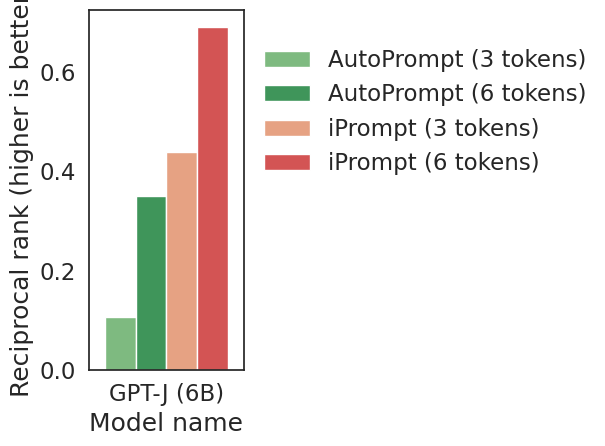

In [37]:
# metric_key = 'final_answer_pos_initial_token'
# metric_key = f'Recall @ {5} suffixes'
metric_key = 'reciprocal_rank'
tab = (
    (autoprompt_results
        # (mean over templates, task_name)
        .groupby(['checkpoint', 'legend'])[[metric_key]]
        .mean()
        .reset_index()
    )
)
analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)

In [38]:
r = pd.concat((suffix_results, autoprompt_results), axis=0)

pd.set_option('display.max_rows', 100)

r.groupby(["legend", "task_name", "n_shots"])[["reciprocal_rank", "prefixes", "max_digit"]].first()

reciprocal_rank  \
legend                task_name     n_shots                    
AutoPrompt (3 tokens) add_two       1           3.571429e-02   
                                    5           1.000000e+00   
                      divide_two    1           1.000000e-10   
                                    5           1.000000e-10   
                      double_one    1           1.000000e-10   
                                    5           1.000000e-10   
                      exp_one       1           1.000000e-10   
                                    5           1.000000e-10   
                      fibonacci_one 1           1.000000e-10   
                                    5           1.000000e-10   
                      first_two     1           1.000000e-10   
                                    5           1.000000e-10   
                      max_two       1           1.000000e-10   
                                    5           1.000000e-10   
                      multiply_two  1           1.000000e+00   
                                    5           1.000000e-10   
                      square_one    1           1.000000e-10   
                                    5           1.000000e-10   
                      subtract_two  1           1.000000e-10   
AutoPrompt (6 tokens) add_two       1           1.000000e+00   
                                    5           1.000000e+00   
                      divide_two    1           1.000000e-10   
                                    5           1.000000e-10   
                      double_one    1           1.000000e-10   
                                    5           1.000000e-10   
                      exp_one       1           9.009009e-03   
                                    5           1.010101e-02   
                      fibonacci_one 1           1.000000e-10   
                                    5           1.000000e-10   
                      first_two     1           1.000000e-10   
                                    5           1.000000e+00   
                      max_two       1           1.000000e-10   
                                    5           1.000000e-10   
                      multiply_two  1           1.000000e+00   
                                    5           1.000000e+00   
                      square_one    1           1.000000e-10   
                                    5           1.000000e-10   
                      subtract_two  1           1.000000e+00   
                                    5           1.000000e+00   
Templated suffix      add_two       1           1.000000e+00   
                                    5           1.000000e+00   
                      divide_two    1           1.000000e+00   
                                    5           1.000000e+00   
                      double_one    1           3.125000e-02   
                                    5           2.127660e-02   
                      exp_one       1           1.298701e-02   
                                    5           7.518797e-03   
                      fibonacci_one 1           1.190476e-02   
                                    5           1.219512e-02   
                      first_two     1           2.500000e-01   
                                    5           3.333333e-01   
                      max_two       1           2.500000e-01   
                                    5           2.500000e-01   
                      multiply_two  1           5.000000e-01   
                                    5           5.000000e-01   
                      square_one    1           5.882353e-02   
                                    5           6.250000e-02   
                      subtract_two  1           1.000000e+00   
                                    5           1.000000e+00   
iPrompt (3 tokens)    add_two       1           1.000000e+00   
                                    5           1.000000e+00   
             

In [39]:
tn = r[["task_name"]].value_counts().reset_index()
finished_task_names = tn[tn[0]==tn[0].max()]["task_name"].tolist()
rf = r[r["task_name"].map(lambda t: t in finished_task_names)] # r_finished

In [40]:
len(r), len(rf)

(98, 80)

In [41]:
len(suffix_results), len(autoprompt_results)

(20, 78)

In [42]:
autoprompt_results.groupby(['model_cls', 'n_shots', 'task_name'])['reciprocal_rank'].mean()

model_cls   n_shots  task_name    
autoprompt  1        add_two          5.178571e-01
                     divide_two       1.000000e-10
                     double_one       1.000000e-10
                     exp_one          4.504505e-03
                     fibonacci_one    1.000000e-10
                     first_two        1.000000e-10
                     max_two          1.000000e-10
                     multiply_two     1.000000e+00
                     square_one       1.000000e-10
                     subtract_two     5.000000e-01
            5        add_two          1.000000e+00
                     divide_two       1.000000e-10
                     double_one       1.000000e-10
                     exp_one          5.050505e-03
                     fibonacci_one    1.000000e-10
                     first_two        5.000000e-01
                     max_two          1.000000e-10
                     multiply_two     5.000000e-01
                     square_one       1.000000e

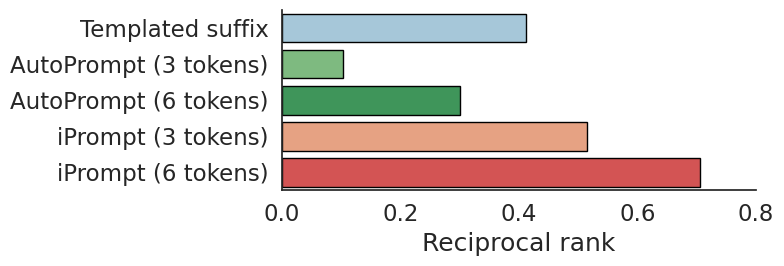

In [58]:
sns.set_theme(font_scale=1.5, style="white")
for metric_key in [
                 'reciprocal_rank',
                #  'final_answer_pos_initial_token',
                #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    tab = (
        (r[r['n_shots'] == 1]
            # (mean over templates, task_name)
            .groupby(['legend'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    hue_order = analyze_utils.get_hue_order(tab['legend'])
    
    g = sns.catplot(
        kind='bar',
        data=tab,
        x='reciprocal_rank',
        y='legend',
        hue='legend',
        order=hue_order,
        hue_order=hue_order,
        palette=analyze_utils.COLORS,
        edgecolor='black',
        orient='h',
        legend=False,
        # figsize=(15,9)
        dodge=False, # make the bars nice and snug
    )
    # for ax in g.axes.flat:
    #     ax.set_xticks([])
    g.fig.set_figwidth(8)
    g.fig.set_figheight(3)
    plt.xlim((0.0, 0.8))
    plt.xlabel('Reciprocal rank')
    plt.ylabel('')
    # plt.legend(False)
    plt.tight_layout()
    if metric_key == 'reciprocal_rank':
        plt.savefig('../results/prompt_gen/joint_math_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_math_{metric_key}.pkl')
    plt.show()

### Plot the best model

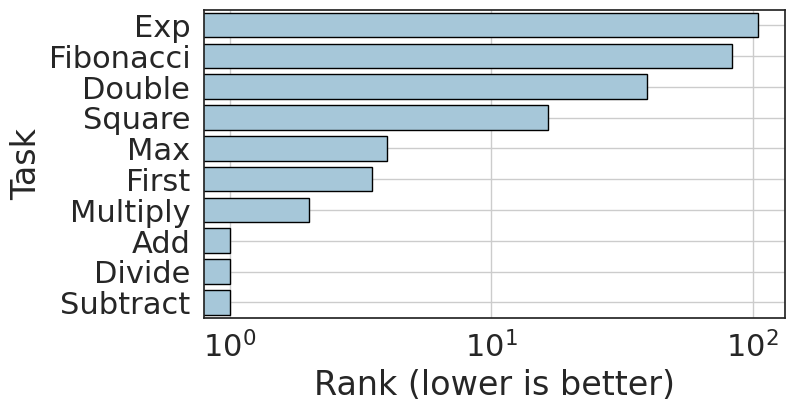

In [67]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(
        data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name],
        edgecolor='black',
        errorbar=None
    ) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Templated suffix')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

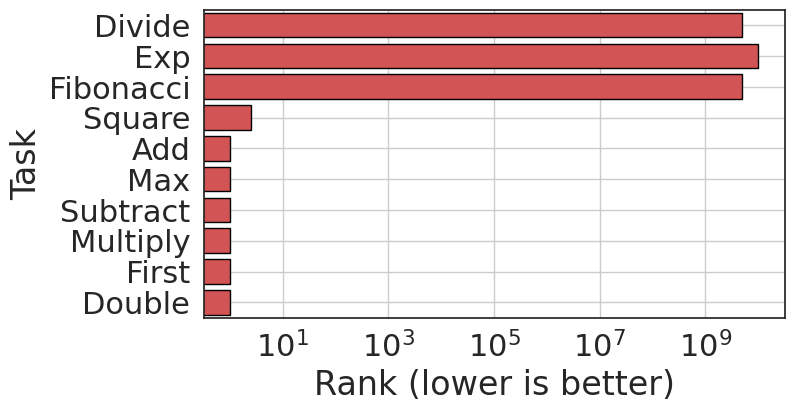

In [68]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(
        data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name],
        edgecolor='black',
        errorbar=None,
    ) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='iPrompt (6 tokens)')
# plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

In [ ]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name]) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Suffix, average-output decoding (4-shot)')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')